In [1]:
import tensorflow as tf
import cv2
import numpy as np
import math

# googLeNet Layers
<img src="https://miro.medium.com/max/1400/1*WfKerFhMvUGti7MWVQ81XQ.png" alt="Italian Trulli">

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

Value of 0 is [6]
Value of 1 is [9]
Value of 2 is [9]
Value of 3 is [4]


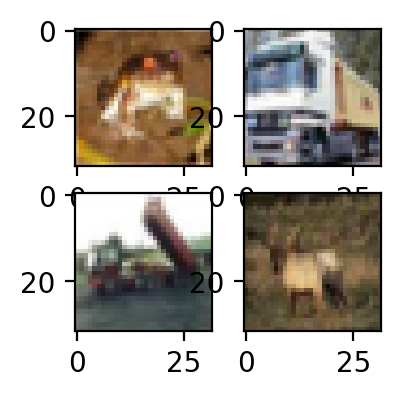

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2, 2), dpi=200)

for i in range(4):
    print('Value of {} is {}'.format(i,y_train[i]))
    fig.add_subplot(2,2,i+1)
    plt.imshow(X_train[i])
plt.show()

In [4]:
def load_dataset(rows,columns,num_classes):
    
    #Loading dataset
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    #Resize traning images
    X_train = np.array([cv2.resize(img,(rows,columns)) for img in X_train[:,:,:]])
    X_test = np.array([cv2.resize(img,(rows,columns)) for img in X_test[:,:,:]])
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    #Transform targets
    y_train = tf.keras.utils.to_categorical(y_train,num_classes)
    y_test = tf.keras.utils.to_categorical(y_test,num_classes)
    
    
    X_train = X_train / 255.0
    X_test = X_test  / 255.0
    
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = load_dataset(224,224,10)

Value of 0 is [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Value of 1 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Value of 2 is [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Value of 3 is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


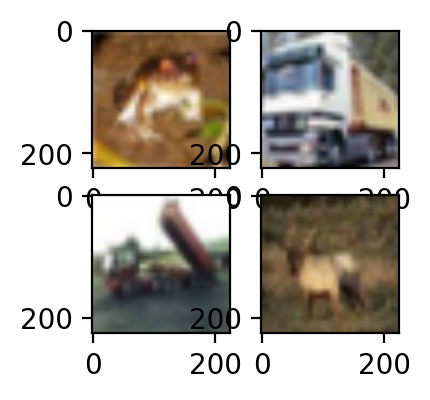

In [6]:
fig = plt.figure(figsize=(2, 2), dpi=200)

for i in range(4):
    print('Value of {} is {}'.format(i,y_train[i]))
    fig.add_subplot(2,2,i+1)
    plt.imshow(X_train[i])
plt.show()

# Inception
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSttSrJJdDX4PMXZIQ1LMHzr4pma9mEqKBMHsfWvID1FzJuXnKj4OAR70zO1QhFGbnBUlc&usqp=CAU" alt="Italian Trulli">

In [7]:
def inception_module(layer,
                    filter_1x1,
                    filter_3x3_reduce,
                    filter_3x3,
                    filter_5x5_reduce,
                    filter_5x5,
                    filter_pool_proj):
    
    conv_1x1 = tf.keras.layers.Conv2D(filter_1x1, kernel_size = (1,1), padding = 'same', activation = 'relu')(layer)
    
    conv_3x3_reduce = tf.keras.layers.Conv2D(filter_3x3_reduce, kernel_size = (1,1), padding = 'same', activation = 'relu')(layer)
    conv_3x3 = tf.keras.layers.Conv2D(filter_3x3, kernel_size = (3,3), padding = 'same', activation = 'relu')(conv_3x3_reduce)
    
    conv_5x5_reduce = tf.keras.layers.Conv2D(filter_5x5_reduce, kernel_size = (1,1), padding = 'same', activation = 'relu')(layer)
    conv_5x5 = tf.keras.layers.Conv2D(filter_5x5, kernel_size = (5,5), padding = 'same', activation = 'relu')(conv_5x5_reduce)
    
    conv_3x3_max_pool = tf.keras.layers.MaxPool2D((3,3), padding = 'same', strides = (1,1))(layer)
    conv_pool_proj = tf.keras.layers.Conv2D(filter_pool_proj, kernel_size = (1,1), padding = 'same', activation = 'relu')(conv_3x3_max_pool)
    
    concat = tf.keras.layers.concatenate([conv_1x1,conv_3x3,conv_5x5, conv_pool_proj], axis = 3)
    
    return concat

# Layer Flow
<img src = "./layer_flow.png">

# Layer Params
<img src = "./layer_params.png">

# Extra fact on intermediate layers

"One interesting insight is that the strong performance
of relatively shallower networks on this task suggests that the features produced by the layers in the
middle of the network should be very discriminative. By adding auxiliary classifiers connected to
these intermediate layers, we would expect to encourage discrimination in the lower stages in the
classifier, increase the gradient signal that gets propagated back, and provide additional regularization. These classifiers take the form of smaller convolutional networks put on top of the output of
the Inception (4a) and (4d) modules"

## So in the middle of the network we have 2 extras classifier layers
- An average pooling layer with 5×5 filter size and stride 3, resulting in an 4×4×512 output for the (4a), and 4×4×528 for the (4d) stage.
- A 1×1 convolution with 128 filters for dimension reduction and rectified linear activation.
- A fully connected layer with 1024 units and rectified linear activation.
- A dropout layer with 70% ratio of dropped outputs.
- A linear layer with softmax loss as the classifier (predicting the same 1000 classes as the main classifier, but removed at inference time).

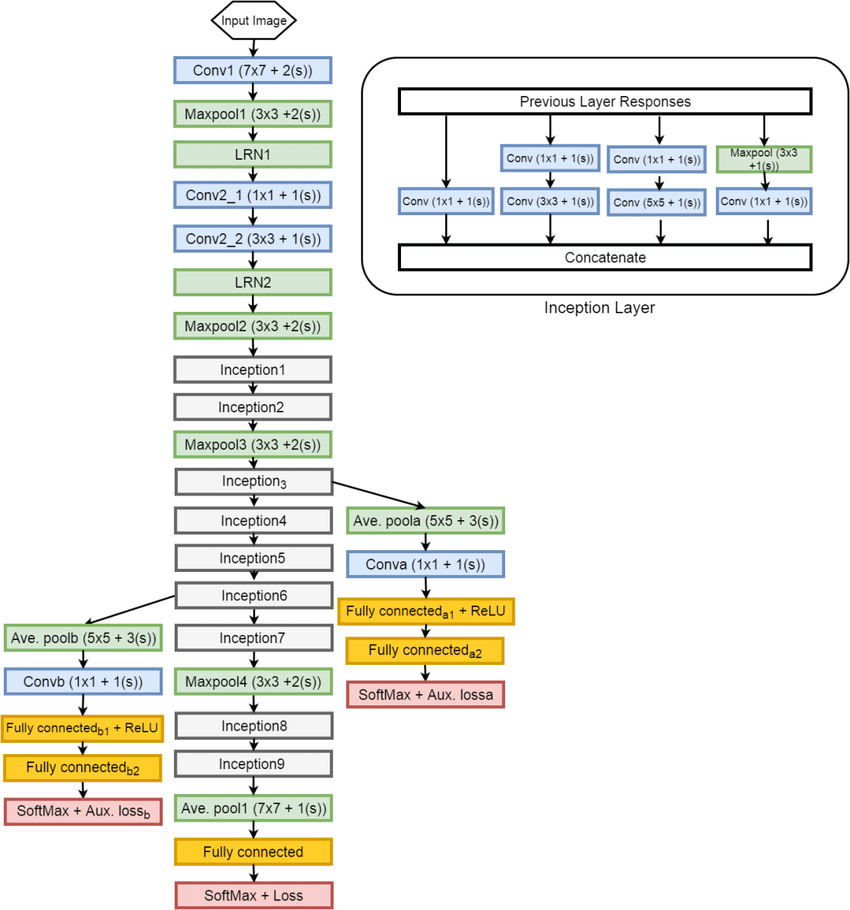

In [8]:
input_image = tf.keras.Input(shape=(224,224,3))

conv1_7x7_2 = tf.keras.layers.Conv2D(64, kernel_size = (7,7), padding = 'same', strides = (2,2),activation = 'relu')(input_image)
max_pool1_3x3_2 = tf.keras.layers.MaxPool2D((3,3), padding = 'same', strides = (2,2))(conv1_7x7_2)
conv2a_3x3_1 = tf.keras.layers.Conv2D(64, kernel_size = (1,1), padding = 'same', strides = (1,1),activation = 'relu')(max_pool1_3x3_2)
conv2b_3x3_1 = tf.keras.layers.Conv2D(192, kernel_size = (3,3), padding = 'same', strides = (1,1),activation = 'relu')(conv2a_3x3_1)
max_pool2_3x3_2 = tf.keras.layers.MaxPool2D((3,3), padding = 'same', strides = (2,2))(conv2b_3x3_1)

inception3a = inception_module(max_pool2_3x3_2,64,96,128,16,32,32)
inception3b = inception_module(inception3a,128,128,192,32,96,64)

max_pool3_3x3_2 = tf.keras.layers.MaxPool2D((3,3), padding = 'same', strides = (2,2))(inception3b)

inception4a = inception_module(max_pool3_3x3_2,192,96,208,16,48,64)


# ----------------------------- Full-connected network part ---------------------------------
avg_pool1 = tf.keras.layers.AveragePooling2D((5,5) , padding = 'same', strides = 3)(inception4a)
conv3_1x1 = tf.keras.layers.Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'relu')(avg_pool1)
flatten1 = tf.keras.layers.Flatten()(conv3_1x1)
dense1 = tf.keras.layers.Dense(1024, activation = 'relu')(flatten1)
dropout1 = tf.keras.layers.Dense(0.7)(dense1)
dense2 = tf.keras.layers.Dense(10, activation = 'softmax')(dropout1)

softmax0 = dense2
# ----------------------------- Full-connected network part ---------------------------------


inception4b = inception_module(inception4a,160,112,224,24,64,64)
inception4c = inception_module(inception4b,128,128,256,24,64,64)
inception4d = inception_module(inception4c,112,144,288,32,64,64)


# ----------------------------- Full-connected network part ---------------------------------
avg_pool2 = tf.keras.layers.AveragePooling2D((5,5), padding = 'same', strides = 3)(inception4d)
conv4_1x1 = tf.keras.layers.Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'relu')(avg_pool2)
flatten2 = tf.keras.layers.Flatten()(conv4_1x1)
dense3 = tf.keras.layers.Dense(1024, activation = 'relu')(flatten2)
dropout2 = tf.keras.layers.Dense(0.7)(dense3)
dense4 = tf.keras.layers.Dense(10, activation = 'softmax')(dropout2)

softmax1 = dense4
# ----------------------------- Full-connected network part ---------------------------------


inception4e = inception_module(inception4d,256,160,320,32,128,128)

max_pool4_3x3_2 = tf.keras.layers.MaxPool2D((3,3), padding = 'same', strides = (2,2))(inception4e)

inception5a = inception_module(max_pool4_3x3_2,256,160,320,32,128,128)
inception5b = inception_module(inception5a,384,192,384,48,128,128)

avg_pool3 = tf.keras.layers.GlobalAveragePooling2D()(inception5b)
dropout3 = tf.keras.layers.Dense(0.4)(avg_pool3)
dense5 = tf.keras.layers.Dense(10, activation = 'softmax')(dropout3)

softmax2 = dense5

# Training Steps

- asynchronous stochastic gradient descent with 0.9 momentum
- fixed learning rate schedule (decreasing the learning rate by 4% every 8 epochs). 
- Polyak averaging was used to create the final model used at inference time.

In [9]:
model = tf.keras.Model(input_image, [softmax0,softmax1,softmax2])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 56, 64)   0           ['conv2d[0][0]']                 
                                                                                              

                                                                                                  
 conv2d_24 (Conv2D)             (None, 14, 14, 224)  226016      ['conv2d_23[0][0]']              
                                                                                                  
 conv2d_26 (Conv2D)             (None, 14, 14, 64)   38464       ['conv2d_25[0][0]']              
                                                                                                  
 conv2d_27 (Conv2D)             (None, 14, 14, 64)   32832       ['max_pooling2d_6[0][0]']        
                                                                                                  
 concatenate_3 (Concatenate)    (None, 14, 14, 512)  0           ['conv2d_22[0][0]',              
                                                                  'conv2d_24[0][0]',              
                                                                  'conv2d_26[0][0]',              
          

 conv2d_51 (Conv2D)             (None, 7, 7, 128)    102528      ['conv2d_50[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 7, 7, 128)    106624      ['max_pooling2d_11[0][0]']       
                                                                                                  
 concatenate_7 (Concatenate)    (None, 7, 7, 832)    0           ['conv2d_47[0][0]',              
                                                                  'conv2d_49[0][0]',              
                                                                  'conv2d_51[0][0]',              
                                                                  'conv2d_52[0][0]']              
                                                                                                  
 average_pooling2d (AveragePool  (None, 5, 5, 512)   0           ['concatenate_2[0][0]']          
 ing2D)   

In [17]:
sgd = tf.keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.9)

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.96
    epochs_drop = 8.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(loss = 'mse', optimizer = sgd, metrics = ['accuracy'])

In [ ]:
history = model.fit(X_train, [y_train, y_train, y_train], validation_data=(X_test, [y_test, y_test, y_test]), epochs=100, callbacks=[lrate])

Epoch 1/100
 105/1563 [=>............................] - ETA: 1:27:50 - loss: 0.2700 - dense_2_loss: 0.0900 - dense_5_loss: 0.0900 - dense_7_loss: 0.0900 - dense_2_accuracy: 0.0899 - dense_5_accuracy: 0.0899 - dense_7_accuracy: 0.0899